In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Mount google drive to access files from Colab

Mounted at /content/drive


In [ ]:
%cd '/content/drive/Othercomputers/My Laptop'
#Changes the current working directory to access the dataset

/content/drive/Othercomputers/My Laptop


In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import models, layers
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix

In [ ]:
# Constant for image processing
IMAGES_SIZE = 224
BATCH_SIZE = 64

In [ ]:
# Load datasets from directories, shuffle it, and resizes images
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/My Laptop/NewDataset2/train',
    shuffle=True,
    image_size=(IMAGES_SIZE, IMAGES_SIZE),
    batch_size=BATCH_SIZE
)


Found 16504 files belonging to 15 classes.


In [ ]:
import os
from prettytable import PrettyTable

train_path = '/My Laptop/NewDataset2/train'

# Get the list of class directories in the train path
class_directories = os.listdir(train_path)

# Create a PrettyTable instance
table = PrettyTable()
table.field_names = ["Class(TRAIN DIR)", "Number of Images"]

# Loop through each class directory and count the number of images
for class_dir in class_directories:
    class_path = os.path.join(train_path, class_dir)
    num_images = len(os.listdir(class_path))
    table.add_row([class_dir, num_images])

# Print the table
print(table)

+---------------------------------------------+------------------+
|               Class(TRAIN DIR)              | Number of Images |
+---------------------------------------------+------------------+
|             Pepper Bell Healthy             |       1182       |
|             Potato Early Blight             |       800        |
|                Potato Healthy               |       121        |
|              Potato Late Blight             |       800        |
|            Tomato Bacterial Spot            |       1701       |
|              Tomato Late Blight             |       1527       |
|             Tomato Early Blight             |       800        |
|                Tomato Healthy               |       1272       |
|               Tomato Leaf Mold              |       761        |
|          Tomato Septoria Leaf Spot          |       1416       |
| Tomato Spider Mites Two Spotted Spider Mite |       1340       |
|              Tomato Target Spot             |       1123    

In [ ]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/Othercomputers/My Laptop/NewDataset2/test',
    shuffle=False,  # No need to shuffle the test set
    image_size=(IMAGES_SIZE, IMAGES_SIZE),
    batch_size=BATCH_SIZE
)

Found 2064 files belonging to 15 classes.


In [ ]:
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/Othercomputers/My Laptop/NewDataset2/validation',
    shuffle=False,  # No need to shuffle the validation set
    image_size=(IMAGES_SIZE, IMAGES_SIZE),
    batch_size=BATCH_SIZE
)

Found 2070 files belonging to 15 classes.


In [ ]:
# Display class names in the dataset
class_names = train_dataset.class_names
class_names

['Pepper Bell Bacterial Spot',
 'Pepper Bell Healthy',
 'Potato Early Blight',
 'Potato Healthy',
 'Potato Late Blight',
 'Tomato Bacterial Spot',
 'Tomato Early Blight',
 'Tomato Healthy',
 'Tomato Late Blight',
 'Tomato Leaf Mold',
 'Tomato Mosaic Virus',
 'Tomato Septoria Leaf Spot',
 'Tomato Spider Mites Two Spotted Spider Mite',
 'Tomato Target Spot',
 'Tomato Yellow Leaf Curl Virus']

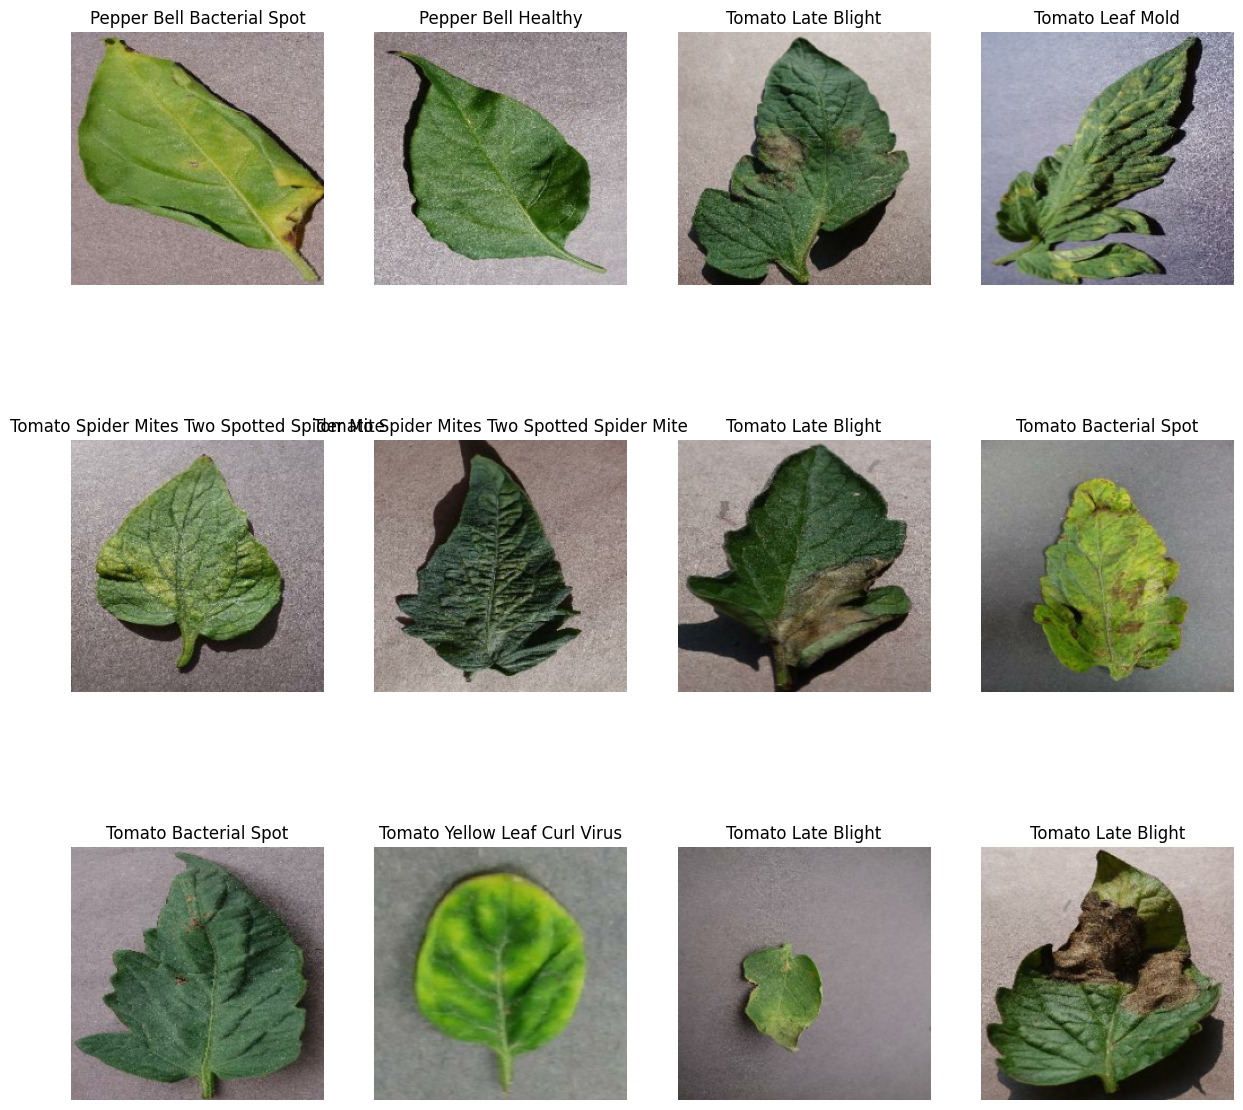

In [ ]:
# Display images from the dataset
plt.figure(figsize=(15, 15))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
      ax = plt.subplot(3, 4, i + 1)
      plt.imshow(image_batch[i].numpy().astype('uint8'))
      plt.title(class_names[label_batch[i]])
      plt.axis('off')

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGES_SIZE, IMAGES_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

input_shape = (IMAGES_SIZE, IMAGES_SIZE, 3)
num_classes = len(class_names)
# Load EfficentNetB0 pre-trained weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# add custom layers on top of the EfficentNetB0 base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 4381362 (16.71 MB)
Trainable params: 331

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [ ]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.96
)

In [ ]:
# Create an optimizer with the scheduler
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# Define a learning rate schedule callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learning_rate(epoch))

In [ ]:
EPOCHS = 40
history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = valid_dataset,
    callbacks = [lr_schedule]
)

Epoch 1/40
258/258 [==============================] - 1477s 6s/step - loss: 1.6841 - accuracy: 0.5170 - val_loss: 0.8983 - val_accuracy: 0.7899 - lr: 1.0000e-04
Epoch 2/40
258/258 [==============================] - 34s 129ms/step - loss: 0.8869 - accuracy: 0.7478 - val_loss: 0.5643 - val_accuracy: 0.8502 - lr: 9.9996e-05
Epoch 3/40
258/258 [==============================] - 34s 130ms/step - loss: 0.6487 - accuracy: 0.8099 - val_loss: 0.4320 - val_accuracy: 0.8792 - lr: 9.9992e-05
Epoch 4/40
258/258 [==============================] - 34s 130ms/step - loss: 0.5267 - accuracy: 0.8440 - val_loss: 0.3571 - val_accuracy: 0.9014 - lr: 9.9988e-05
Epoch 5/40
258/258 [==============================] - 35s 131ms/step - loss: 0.4534 - accuracy: 0.8658 - val_loss: 0.3074 - val_accuracy: 0.9179 - lr: 9.9984e-05
Epoch 6/40
258/258 [==============================] - 35s 131ms/step - loss: 0.4074 - accuracy: 0.8780 - val_loss: 0.2735 - val_accuracy: 0.9275 - lr: 9.9980e-05
Epoch 7/40
258/258 [=========

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy}')

33/33 [==============================] - 175s 5s/step - loss: 0.0661 - accuracy: 0.9826
Test Accuracy: 0.9825581312179565


In [ ]:
# Calculate additional metrics
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

33/33 [==============================] - 5s 108ms/step


In [ ]:
# Calculate accuracy rate
accuracy_rate = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy Rate: {accuracy_rate}')

Accuracy Rate: 0.9825581395348837


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(true_labels, predicted_labels, average = 'weighted')
print(f'F1 Score: {f1}')

F1 Score: 0.9825748379345871


In [ ]:
# Calculate error rate
error_rate = 1 - accuracy_rate
print(f'Error Rate: {error_rate}')

Error Rate: 0.018410852713178327


In [ ]:
# Display confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[100   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1 147   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  99   0   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  14   1   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0  98   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0 212   0   0   0   0   0   1   0   0   0]
 [  0   0   1   0   1   0  94   0   1   0   0   1   1   1   0]
 [  0   0   0   0   0   0   0 156   0   0   0   1   0   2   0]
 [  0   0   0   0   0   0   1   1 187   0   0   1   0   1   0]
 [  0   0   0   0   0   0   0   0   2  92   0   0   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0  37   0   0   0   0]
 [  0   0   0   0   0   3   0   0   1   0   0 172   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 161   7   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   1 138   0]
 [  0   0   0   0   0   1   0   0   0   0   0   0   1   0 319]]


In [ ]:
# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')
print(f'Recall: {recall}')

Recall: 0.9815891472868217


In [ ]:
from sklearn.metrics import precision_score

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')
print(f'Precision: {precision}')

Precision: 0.9819781518690109


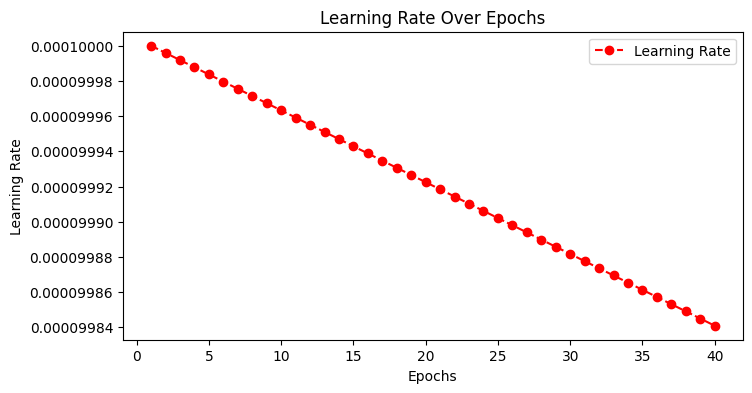

In [ ]:
# Access the learning rate during training
learning_rates = history.history['lr']
epochs_range = range(1, EPOCHS + 1)
# Plot learning rates
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, learning_rates, label='Learning Rate', marker='o', linestyle='--', color='r')
plt.title('Learning Rate Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()


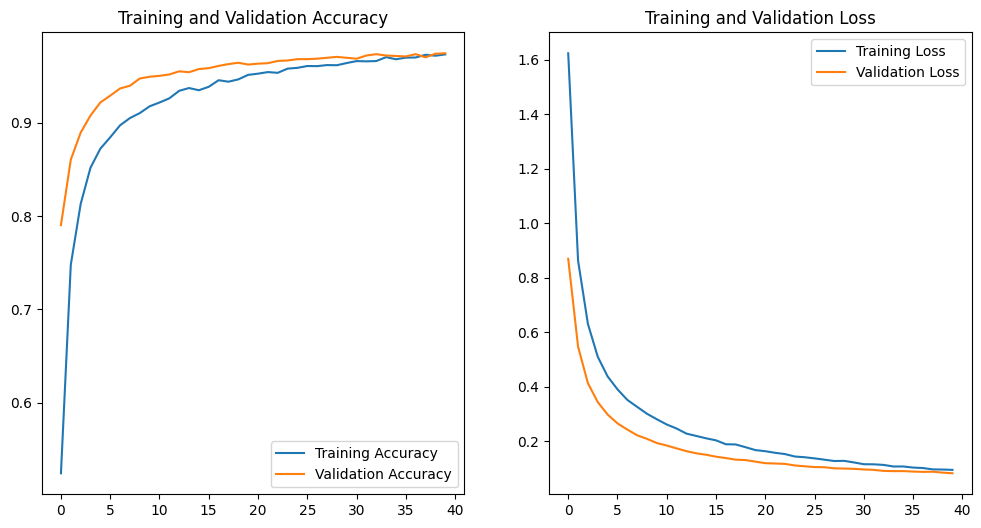

In [ ]:
# Plot training and validation curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
model.save("/content/drive/Othercomputers/My Laptop/NewDataset2/CNN(Model3_EfficientNetB0).h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


first image prediction
actual label: Pepper Bell Bacterial Spot
2/2 [==============================] - 3s 20ms/step
predicted label: Pepper Bell Bacterial Spot


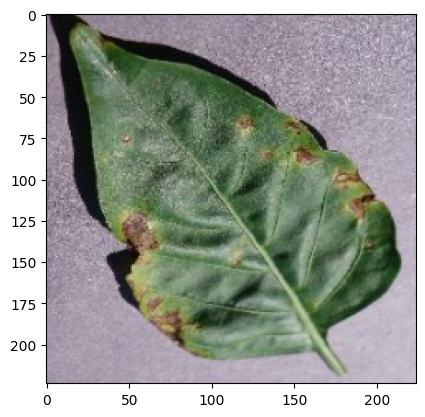

In [ ]:
for images_batch, labels_batch in test_dataset.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image prediction")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(15):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Predicted Class: {predicted_class},\n Actual Class: {actual_class},\n Confidence: {confidence}")
        plt.axis("off")

plt.show()

Output hidden; open in https://colab.research.google.com to view.